# Simultaneous Quantiles

---

---

### Overview

This notebook trains two variations of models which can be used to estimate aleatoric uncertainty.  The first does not include any additional monotonic features, and the second does.

A special loss function is used that allows us to predict any quantile with a single training step, and to change that quantile arbitrarily, without requiring retraining.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tabularasa.SimultaneousQuantiles import SimultaneousQuantilesRegressor, SimultaneousQuantilesNet, SimultaneousQuantilesMixedMonotonicNet

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

---

### Train a model without monotonicity constraints

Similar to `MixedMonotonicNet()`, `SimultaneousQuantilesNet()` takes another network as an input argument whose `.forward()` pass has exactly one input named `X_non_monotonic` (`SimultaneousQuantilesRegressor()` adds an extra feature which is monotonically constrained to estimate the quantile).

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(3 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1:].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

`module__` parameters are similar to the [mixed_monotonic](./mixed_monotonic.ipynb) example, with the exception of not needing `dim_monotonic` as input.

In [4]:
model = SimultaneousQuantilesRegressor(SimultaneousQuantilesNet,
                                       max_epochs=100,
                                       lr=0.01,
                                       optimizer=torch.optim.Adam,
                                       iterator_train__shuffle=True,
                                       module__non_monotonic_net=EmbeddingNet(),
                                       module__dim_non_monotonic=16,
                                       module__layers=[128, 128, 32],
                                       module__integration_steps=300)

Now we can pass in a `dict` with only one key `X_non_monotonic` to our model's `.fit()` method.  Note, that `x1` and `x2` are listed after `x3` to align with how `EmbeddingNet()` parses `X_non_monotonic`.

The loss function for `SimultaneousQuantilesRegressor()` is mean pinball loss, where the quantiles are randomly distributed for each observation, and change with each epoch.  More details can be found in [Tagasovska and Lopez-Paz (2018)](https://arxiv.org/pdf/1811.00908.pdf).

In [5]:
model.fit({'X_non_monotonic': df[['x3', 'x4', 'x1', 'x2']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2051        0.1686  4.7796
      2        0.1646        0.1586  4.5204
      3        0.1555        0.1577  4.4106
      4        0.1387        0.1379  4.4654
      5        0.1352        0.1339  4.4695
      6        0.1166        0.1198  4.5279
      7        0.0922        0.1024  4.4616
      8        0.0848        0.0935  4.4001
      9        0.0798        0.0937  4.4247
     10        0.0706        0.0844  4.4781
     11        0.0638        0.0927  4.4198
     12        0.0630        0.0922  4.5184
     13        0.0673        0.0881  4.4965
     14        0.0626        0.0890  4.3984
     15        0.0672        0.0810  4.4449
     16        0.0669        0.0710  4.4864
     17        0.0614        0.0828  4.3883
     18        0.0629        0.0943  4.4541
     19        0.0611        0.0880  4.4633
     20        0.0534        0.0747  4.5279
     21        0.0521        0.0

<class 'tabularasa.SimultaneousQuantiles.SimultaneousQuantilesRegressor'>[initialized](
  module_=SimultaneousQuantilesNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=19, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
   

---

### Aleatoric uncertainty

Since each distinct value of `x3` contains all values of `x1`, let's examine prediction intervals by `x1` for a single value of `x3`.

In [6]:
df_slice = df[df['x3'] == 0].copy()

`SimulatedQuantilesRegressor().predict()` takes in an extra argument `q` to specify which quantile should be predicted (defaults to 0.5, the 50th percentile).

In [7]:
p05 = model.predict({'X_non_monotonic': df_slice[['x3', 'x4', 'x1', 'x2']].values}, q=0.05)
p50 = model.predict({'X_non_monotonic': df_slice[['x3', 'x4', 'x1', 'x2']].values}, q=0.5)
p95 = model.predict({'X_non_monotonic': df_slice[['x3', 'x4', 'x1', 'x2']].values}, q=0.95)

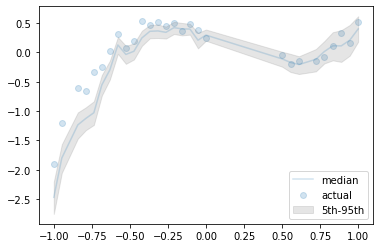

In [9]:
plt.scatter(df_slice['x1'], df_slice['y'], alpha=0.2, label='actual')
plt.plot(df_slice['x1'], p50.flatten(), alpha=0.2, label='median')
plt.fill_between(df_slice['x1'], p05.flatten(), p95.flatten(), color='gray', alpha=0.2, label='5th-95th')
plt.legend()
plt.show()

This does not look good at all...  Maybe I was just overfitting.

Wider interval here, but much worse fit... I wonder if something is happening with my random number generation?

Nope, not random numbers.

Even when I'm not terribly overfitting, a large number of epochs just seems to shrink the bands way too much.

I guess maybe this is OK since the fit is getting good enough that the band doesn't have to be that wide?

In [4]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [5]:
model = SimultaneousQuantileRegressor(SimultaneousQuantileMixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [6]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5811        0.4595  10.3075
      2        0.3487        0.2315  9.4292
      3        0.2238        0.2295  9.2418
      4        0.2224        0.1868  9.2474
      5        0.2035        0.2347  9.2152
      6        0.2024        0.1963  8.7851
      7        0.2000        0.2031  8.8613
      8        0.2014        0.1922  8.8707
      9        0.1924        0.2000  9.0655
     10        0.1878        0.1973  8.9809
     11        0.1982        0.1897  8.9462
     12        0.1923        0.2135  8.8839
     13        0.1925        0.1929  8.7842


<class 'tabularasa.SimultaneousQuantileRegressor.SimultaneousQuantileRegressor'>[initialized](
  module_=SimultaneousQuantileMixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
       

In [7]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [8]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

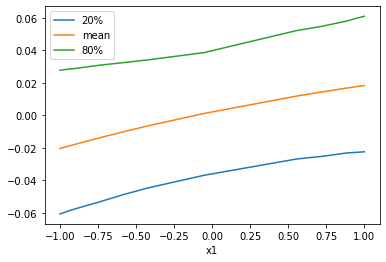

In [9]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

In [10]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values})

array([[-0.00588573],
       [ 0.04773763],
       [ 0.06194977],
       ...,
       [ 0.0665164 ],
       [ 0.07168144],
       [ 0.06724489]], dtype=float32)

In [11]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.5)

array([[-0.00588573],
       [ 0.04773763],
       [ 0.06194977],
       ...,
       [ 0.0665164 ],
       [ 0.07168144],
       [ 0.06724489]], dtype=float32)

In [12]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.9)

array([[2.5714515e-05],
       [4.9877182e-02],
       [6.4310715e-02],
       ...,
       [6.8276986e-02],
       [7.3422000e-02],
       [6.8904407e-02]], dtype=float32)

In [13]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.1)

array([[-0.0120576 ],
       [ 0.04543061],
       [ 0.05940571],
       ...,
       [ 0.06460671],
       [ 0.06979516],
       [ 0.06544493]], dtype=float32)

In [14]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.5, last_hidden_layer=True)

array([[1.8008924, 1.       , 1.8807808, ..., 2.6754327, 1.8818873,
        1.       ],
       [2.2934756, 1.       , 2.3940916, ..., 3.5926368, 2.3543181,
        1.       ],
       [2.2879782, 1.       , 2.372876 , ..., 3.5557475, 2.3435197,
        1.       ],
       ...,
       [2.653592 , 1.       , 2.5795307, ..., 4.14019  , 2.5826511,
        1.       ],
       [2.661717 , 1.       , 2.590844 , ..., 4.161422 , 2.5904365,
        1.       ],
       [2.6822915, 1.       , 2.604792 , ..., 4.198989 , 2.6081073,
        1.       ]], dtype=float32)